![ML4VA Picture](https://nuedusec.com/blog/wp-content/uploads/2019/11/cyberbullying.png)

# Watch Your Mouth, Virginia

**Machine Learning for Virginia**

Kyle Cheng, kwc9ap  
Iain Muir, iam9ez  
Boris Topalov, bnt4yb  

This project analyzes offensive language on the internet through the lens of Machine Learning. We use Natural Language Processing (NLP) models to categorize text commentary taken from social media websites into two categories: offensive language and non-offensive language.

# 1) Import Data

## **Download from Kaggle**
First we will download the dataset from Kaggle.

In order to do this you must obtain an API key from Kaggle. 

Go to [Kaggle](https://kaggle.com) and log in, then click on your circular profile icon in the top right corner, and then click on account and scroll down to API and click Create new API Token.

In [101]:
!pip install -q kaggle
from google.colab import files

# upload the kaggle.json file downloaded when you obtained the API key 
# in the steps described above 
files.upload() 

!rm -r ~/.kaggle
!mkdir ~/.kaggle
!mv ./kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json

Saving kaggle.json to kaggle.json


In [102]:
!mkdir /content/insults
!kaggle competitions download -c detecting-insults-in-social-commentary -p /content/insults

mkdir: cannot create directory ‘/content/insults’: File exists
sample_submission_null.csv: Skipping, found more recently modified local copy (use --force to force download)
test.csv: Skipping, found more recently modified local copy (use --force to force download)
test_with_solutions.csv: Skipping, found more recently modified local copy (use --force to force download)
impermium_verification_labels.csv: Skipping, found more recently modified local copy (use --force to force download)
train.csv: Skipping, found more recently modified local copy (use --force to force download)
impermium_verification_set.csv: Skipping, found more recently modified local copy (use --force to force download)


In [103]:
ROOT =  '/content/insults/'

In [104]:
SEED = 42

#### Training Data

In [105]:
import pandas as pd

train = pd.read_csv(ROOT + 'train.csv')
insults_train = train
insults_train.head()

,Insult,Date,Comment
0,1,20120618192155Z,"""You fuck your dad."""
1,0,20120528192215Z,"""i really don't understand your point.\xa0 It ..."
2,0,NaN,"""A\\xc2\\xa0majority of Canadians can and has ..."
3,0,NaN,"""listen if you dont wanna get married to a man..."
4,0,20120619094753Z,"""C\xe1c b\u1ea1n xu\u1ed1ng \u0111\u01b0\u1edd..."


In [106]:
insults_train.shape

(3947, 3)

In [107]:
insults_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3947 entries, 0 to 3946
Data columns (total 3 columns):
 #   Column   Non-Null Count  Dtype 
---  ------   --------------  ----- 
 0   Insult   3947 non-null   int64 
 1   Date     3229 non-null   object
 2   Comment  3947 non-null   object
dtypes: int64(1), object(2)
memory usage: 92.6+ KB


In [108]:
insults_train.shape

(3947, 3)

In [109]:
y_true_train = insults_train['Insult']

#### Testing Data

In [110]:
test = pd.read_csv(ROOT + 'test_with_solutions.csv')
insults_test = test
insults_test.head()

,Insult,Date,Comment,Usage
0,0,NaN,"""THE DRUDGE REPORT\\n\\n\\n\\nYou won't see th...",PublicTest
1,0,20120618222256Z,"""@ian21\xa0""Roger Clemens is the fucking man, ...",PublicTest
2,1,20120618213617Z,"""Agree with Alan you are an extremest idiot. ...",PublicTest
3,0,NaN,"""Really?\\n\\nI see Marc Lamont Hill on variou...",PrivateTest
4,0,20120620003825Z,"""Really suck isn't the word, when many of our ...",PrivateTest


In [111]:
insults_test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2647 entries, 0 to 2646
Data columns (total 4 columns):
 #   Column   Non-Null Count  Dtype 
---  ------   --------------  ----- 
 0   Insult   2647 non-null   int64 
 1   Date     2123 non-null   object
 2   Comment  2647 non-null   object
 3   Usage    2647 non-null   object
dtypes: int64(1), object(3)
memory usage: 82.8+ KB


In [112]:
insults_test.shape

(2647, 4)

In [113]:
y_true_test = insults_test['Insult']

# 2) Scikit-Learn Data Preprocessing

We start off by transforming the text data into a vectorized representation. 
* Count Vectorizer
* TF-IDF Transformer
* Stemming

In [114]:
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.pipeline import Pipeline
from nltk.corpus import stopwords
import sklearn
import string
import nltk
import re

#### Pipeline

In [115]:
# SRC: https://www.nltk.org/data.html
nltk.download('stopwords')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

In [116]:
stemmer = nltk.stem.snowball.SnowballStemmer(
    'english', ignore_stopwords=True
)

In [117]:
# SRC: https://towardsdatascience.com/machine-learning-nlp-text-classification-using-scikit-learn-python-and-nltk-c52b92a7c73a

class StemmedCountVectorizer(CountVectorizer):
    """
    Super Class: CountVectorizer
    """

    def build_analyzer(self):
        """

        """
        analyzer = super(StemmedCountVectorizer, self).build_analyzer()
        return lambda doc: ([stemmer.stem(w) for w in analyzer(doc)])

In [118]:
# SRC: https://medium.com/@eiki1212/natural-language-processing-naive-bayes-classification-in-python-e934365cf40c

pipeline = Pipeline([
    ('stem_vect', StemmedCountVectorizer(stop_words='english')),
    ('tfidf', TfidfTransformer())
])

In [119]:
X_train_prepared = pipeline.fit_transform(insults_train['Comment'])
X_test_prepared = pipeline.transform(insults_test['Comment'])

In [120]:
X_train_prepared.shape

(3947, 12493)

In [121]:
X_test_prepared.shape

(2647, 12493)

# 3) Baseline Naive-Bayes Classifier

#### Initial Model Training

We are going to be using a Naive-Bayes classifier with minimal preprocessing as a baseline.

In [122]:
from sklearn.naive_bayes import MultinomialNB

mnb_clf = MultinomialNB()
mnb_insults = mnb_clf.fit(
    X_train_prepared, y_true_train
)

In [123]:
y_pred_test = mnb_insults.predict(X_test_prepared)

In [124]:
X_test_prepared

<2647x12493 sparse matrix of type '<class 'numpy.float64'>'
	with 33791 stored elements in Compressed Sparse Row format>

In [125]:
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix

print(classification_report(y_true_test, y_pred_test))

              precision    recall  f1-score   support

           0       0.77      0.99      0.86      1954
           1       0.88      0.14      0.24       693

    accuracy                           0.77      2647
   macro avg       0.82      0.57      0.55      2647
weighted avg       0.80      0.77      0.70      2647



#### Hyperparameter Tuning

In [126]:
PARAMS = {
    'alpha': [1, 1e-1, 1e-2, 1e-3, 1e-4]
}

In [127]:
from sklearn.model_selection import GridSearchCV

mnb_gscv = GridSearchCV(
    MultinomialNB(), 
    PARAMS, 
    cv=10,
    scoring='accuracy',
    return_train_score=True
)

mnb_gscv.fit(
    X_train_prepared, y_true_train
)

GridSearchCV(cv=10, estimator=MultinomialNB(),
             param_grid={'alpha': [1, 0.1, 0.01, 0.001, 0.0001]},
             return_train_score=True, scoring='accuracy')

In [128]:
mnb_gscv.best_params_

{'alpha': 0.1}

In [129]:
mnb_gscv.best_score_

0.7864280665681425

In [130]:
y_pred_tune = mnb_gscv.best_estimator_.predict(X_test_prepared)

In [131]:
from sklearn.metrics import roc_curve, roc_auc_score, auc
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

In [132]:
def plot_confusion_matrix(y_true, y_pred):
    """
    @param y_true
    @param y_pred
    """
    # STEP 1: sklearn confusion matrix
    cm = confusion_matrix(y_true_test, y_pred)

    # STEP 2: generate labels
    group_names = ['True Neg','False Pos','False Neg','True Pos']
    group_percentages = [
        '{0:.2%}'.format(value) 
        for value in cm.flatten()/np.sum(cm)
    ]
    labels = [
        f'{v1}\n{v2}' 
        for v1, v2 in zip(group_names, group_percentages)
    ]
    labels = np.asarray(labels).reshape(2,2)

    # STEP 3: plot using seaborn
    plt.figure(figsize=(18, 10))
    sns.heatmap(cm, annot=labels, fmt='', cmap='Blues')
    plt.show()

In [133]:
def plot_roc_auc(fpr, tpr, auc):
    """
    @param - fpr
    @param - tpr
    @param - auc
    """
    plt.figure()
    lw = 2
    plt.plot(
        fpr,
        tpr,
        color="darkorange",
        lw=lw,
        label="ROC curve (area = %0.2f)" % auc,
    )
    plt.plot([0, 1], [0, 1], color="navy", lw=lw, linestyle="--")
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel("False Positive Rate")
    plt.ylabel("True Positive Rate")
    plt.title("Receiver Operating Characteristic")
    plt.legend(loc="lower right")
    plt.show()

In [134]:
print(classification_report(y_true_test, y_pred_tune))

              precision    recall  f1-score   support

           0       0.82      0.96      0.88      1954
           1       0.78      0.40      0.53       693

    accuracy                           0.81      2647
   macro avg       0.80      0.68      0.71      2647
weighted avg       0.81      0.81      0.79      2647



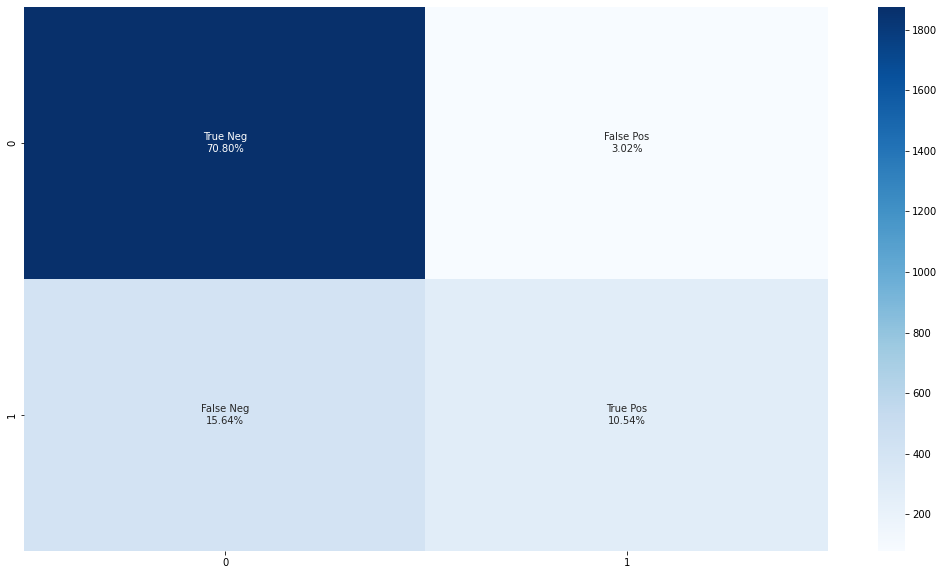

In [135]:
plot_confusion_matrix(y_true_test, y_pred_tune)

In [136]:
fpr, tpr, _ = roc_curve(y_true_test, y_pred_tune)
roc_auc = auc(fpr, tpr)

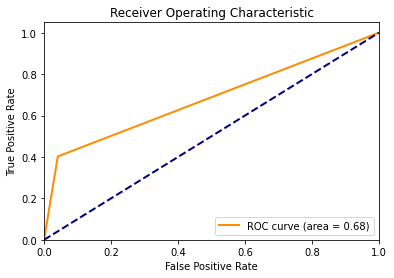

In [137]:
plot_roc_auc(fpr, tpr, roc_auc)

#### Performance Commentary

**Initial Performance**

Terrible recall on the positive case! When the classifier predicts positive, it is usually right but it doesn't predict positive as much as it should. We will try a SVM clasifier next, and tune hyperparameters for both multinomial Naive Bayes and SVM for comparison.

**Post-Tuning Performance**  

After hyperparameter tuning, we saw a massive improvement in positive case recall, from .12 to .40. Overall accuracy went from 77% to 81%.

# 4) Support Vector Machine

#### Initial Model Training

In [138]:
from sklearn.linear_model import SGDClassifier

sgd_clf = SGDClassifier()
svm_insults = sgd_clf.fit(
    X_train_prepared, y_true_train
)

In [139]:
y_pred_test = svm_insults.predict(X_test_prepared)

In [140]:
print(classification_report(y_true_test, y_pred_test))

              precision    recall  f1-score   support

           0       0.85      0.91      0.88      1954
           1       0.69      0.56      0.62       693

    accuracy                           0.82      2647
   macro avg       0.77      0.73      0.75      2647
weighted avg       0.81      0.82      0.81      2647



#### Hyperparameter Tuning

Much better than the baseline Naive-Bayes classifier! Still not quite where we would want our model. Lets tune hyperparameters

In [141]:
PARAMS = {
    'loss': ['hinge', 'squared_hinge'],
    'penalty': ['l2', 'l1', 'elasticnet'], 
    'alpha': [.00006, .0001, .0003, .0006, .001, .003, .006]
}

In [142]:
svm_gscv = GridSearchCV(
    SGDClassifier(random_state=SEED, max_iter=4000), 
    PARAMS, 
    cv=5,
    scoring='neg_mean_squared_error',
    return_train_score=True
)

svm_gscv.fit(
    X_train_prepared, y_true_train
)

/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_stochastic_gradient.py:700: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  ConvergenceWarning,
/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_stochastic_gradient.py:700: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  ConvergenceWarning,
/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_stochastic_gradient.py:700: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  ConvergenceWarning,
/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_stochastic_gradient.py:700: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  ConvergenceWarning,
/usr/local/lib/python3.7/dist-packages/sklearn/linear_mo

GridSearchCV(cv=5, estimator=SGDClassifier(max_iter=4000, random_state=42),
             param_grid={'alpha': [6e-05, 0.0001, 0.0003, 0.0006, 0.001, 0.003,
                                   0.006],
                         'loss': ['hinge', 'squared_hinge'],
                         'penalty': ['l2', 'l1', 'elasticnet']},
             return_train_score=True, scoring='neg_mean_squared_error')

In [143]:
svm_gscv.best_params_

{'alpha': 0.0006, 'loss': 'squared_hinge', 'penalty': 'elasticnet'}

In [144]:
svm_gscv.best_score_

-0.17202868556576983

In [145]:
y_pred_tune = svm_gscv.best_estimator_.predict(X_test_prepared)

In [146]:
print(classification_report(y_true_test, y_pred_tune))

              precision    recall  f1-score   support

           0       0.84      0.95      0.89      1954
           1       0.79      0.48      0.60       693

    accuracy                           0.83      2647
   macro avg       0.81      0.72      0.74      2647
weighted avg       0.82      0.83      0.81      2647



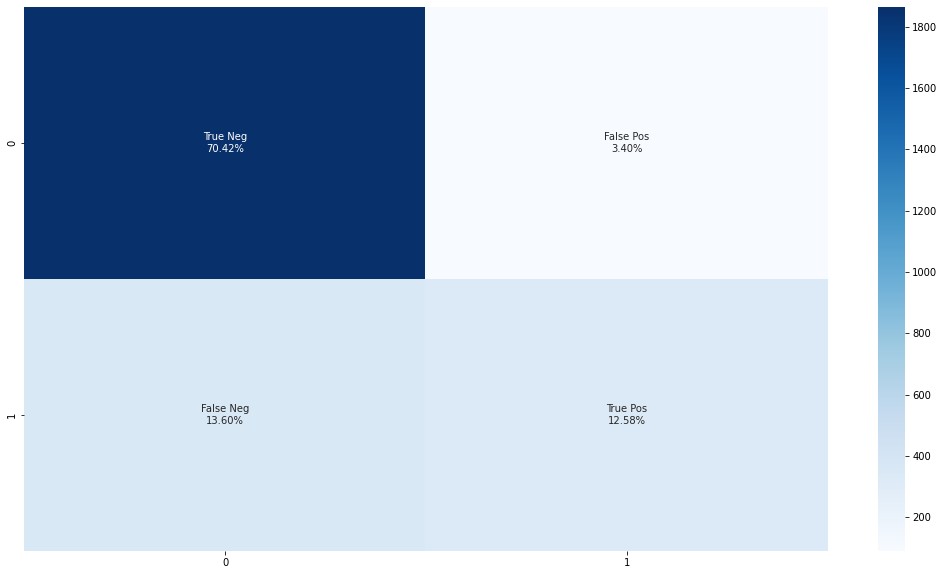

In [147]:
plot_confusion_matrix(y_true_test, y_pred_tune)

In [148]:
fpr, tpr, _ = roc_curve(y_true_test, y_pred_tune)
roc_auc = auc(fpr, tpr)

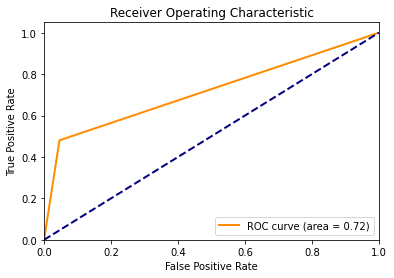

In [149]:
plot_roc_auc(fpr, tpr, roc_auc)

#### Performance Commentary

**Initial Performance**  
Better than the untuned Naive-Bayes and similar performance to the tuned Naive-Bayes model. In general, SVM models seem to do much better at recognizing the positive case than Naive-Bayes models.


**Post-Tuning Performance**   
Tuned SVM has better F1 scores and overall accuracy, 83% compared to pretuned SVM's 81%, but worse recall on the positive case. This may be ok, it makes sense to want higher precision in offensive language detection. So far, the best model for our problem.

# 5) Keras Data Preprocessing

Our Data preprocessing for our Keras NLP model is a bit different than the process used for our SKLearn models. The main reason for this is due to the difference in vectorization between the two. In our Keras model, we use Keras's Tokenization class to vectorize inputs. We wanted to use Keras's libraries for data processing for our NLP model, and SKLearn's libraries for our SKLearn models. 

While we recognize that this creates an inconsistency in the way data gets cleaned prior to the model being trained, we believe that using cleaning methods tailored to each model leads to better results. 

In [150]:
import matplotlib.pyplot as plt
import matplotlib as mpl

%tensorflow_version 2.x
from tensorflow import keras
import tensorflow as tf

np.random.seed(SEED)
tf.random.set_seed(SEED)

#### Validation Dataset

In [151]:
TRAIN_SIZE = int(train.shape[0] * 0.8)

In [152]:
insults_train = train[:TRAIN_SIZE]
insults_val = train[TRAIN_SIZE:]
insults_test = test

In [153]:
y_true_train = insults_train['Insult']
y_true_val = insults_val['Insult']
y_true_test = insults_test['Insult']

#### Text Cleaning

In [154]:
nltk.download('stopwords')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

In [155]:
def remove_punct(text):
    """
    @param text - each individual comment (string)

    Removes punctuation from the text

    @return
    """
    translator = str.maketrans("", "", string.punctuation)
    return text.translate(translator)

def remove_stopwords(text):
    """
    @param text - each individual comment (string)

    Remove stopwords (ex. the, it) — the most common words in the english 
    language which generally won't add value to our analysis

    @return
    """
    stop = set(stopwords.words("english"))
    filtered_words = [word.lower() for word in text.split() if word.lower() not in stop]
    return " ".join(filtered_words)

def remove_nbsp(text):
    """
    @param text - each individual comment (string)

    Remove Non-Breaking Spaces

    @return
    """
    text = text.replace(u'\xa0', u' ')
    return text

def remove_url(text):
    """
    @param text - each individual comment (string)

    Remove any URLs in the text using Regular Expressions

    @return
    """
    url = re.compile(r"(https|http)?://\S+|www\.\S+")
    return url.sub(r"", text)

In [156]:
def clean_text(text):
    """
    @param text - each individual comment (string)

    Call each individual helper function to clean each comment

    @return cleaned comments
    """
    text = remove_punct(text)
    text = remove_stopwords(text)
    text = remove_nbsp(text)
    text = remove_url(text)
    return text 

In [157]:
insults_train['Comment'] = insults_train.Comment.map(clean_text)
insults_test["Comment"] = insults_test.Comment.map(clean_text)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.


In [158]:
TRAIN_SIZE = int(train.shape[0] * 0.8)

In [159]:
insults_train = train[:TRAIN_SIZE]
insults_val = train[TRAIN_SIZE:]
insults_test = test

In [160]:
y_true_train = insults_train['Insult']
y_true_val = insults_val['Insult']
y_true_test = insults_test['Insult']

#### Shuffle

In [161]:
from sklearn.utils import shuffle

#insults_train = shuffle(insults_train)
#insults_val = shuffle(insults_val)
#insults_test = shuffle(insults_test)

In [162]:
#insults_train.reset_index(inplace=True, drop=True) 
#insults_val.reset_index(inplace=True, drop=True) 
#insults_test.reset_index(inplace=True, drop=True) 

#### Tokenization

In [163]:
from collections import Counter

def counter_word(text_col):
    """
    @param text_col -

    Count unique words

    @return
    """
    count = Counter()
    for text in text_col.values:
        for word in text.split():
            count[word] += 1
    return count

In [164]:
counter = counter_word(insults_train['Comment'])
num_unique_words = len(counter)
num_unique_words

15937

In [165]:
from tensorflow.keras.preprocessing.text import Tokenizer

tokenizer = Tokenizer(num_words=num_unique_words)
# Only fit on training set 
tokenizer.fit_on_texts(insults_train['Comment']) 

In [166]:
train_sequences = tokenizer.texts_to_sequences(insults_train['Comment'])
val_sequences = tokenizer.texts_to_sequences(insults_val['Comment'])
test_sequences = tokenizer.texts_to_sequences(insults_test['Comment'])

#### Padding

Pad the sequences to have the same length

In [167]:
from tensorflow.keras.preprocessing.sequence import pad_sequences

# Max number of words in a sequence
MAX_LENGTH = 70 # 280 character limit in a tweet so this should be a good limit

In [168]:
train_padded = np.array(pad_sequences(
    train_sequences, maxlen=MAX_LENGTH, padding="post", truncating="post"
))
val_padded = np.array(pad_sequences(
    val_sequences, maxlen=MAX_LENGTH, padding="post", truncating="post"
))
test_padded = np.array(pad_sequences(
    test_sequences, maxlen=MAX_LENGTH, padding="post", truncating="post"
))
train_padded.shape, val_padded.shape, test_padded.shape

((3157, 70), (790, 70), (2647, 70))

# 6) Keras Neural Networks

## Neural Network I

#### Initial Model Training

In [169]:
EMBED_DIM = 32

In [170]:
model = tf.keras.Sequential([
    tf.keras.layers.Embedding(
        num_unique_words, EMBED_DIM, input_length=MAX_LENGTH
    ),
    tf.keras.layers.Conv1D(32,5,activation='relu',padding="same"),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.Dropout(.2),
    tf.keras.layers.MaxPool1D(),
    tf.keras.layers.Conv1D(32,3,activation='relu',padding="same"),
    tf.keras.layers.Dropout(.2),
    tf.keras.layers.MaxPool1D(),
    tf.keras.layers.Conv1D(32,3,activation='relu',padding="same"),
    tf.keras.layers.Dropout(.2),
    tf.keras.layers.MaxPool1D(),
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(250, activation='relu'),
    tf.keras.layers.Dropout(.5),
    tf.keras.layers.Dense(32, activation='relu'),
    tf.keras.layers.Dropout(.25),
    tf.keras.layers.Dense(1, activation='sigmoid'),
])

In [171]:
model.summary()

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_3 (Embedding)     (None, 70, 32)            509984    
                                                                 
 conv1d_9 (Conv1D)           (None, 70, 32)            5152      
                                                                 
 batch_normalization_3 (Batc  (None, 70, 32)           128       
 hNormalization)                                                 
                                                                 
 dropout_15 (Dropout)        (None, 70, 32)            0         
                                                                 
 max_pooling1d_9 (MaxPooling  (None, 35, 32)           0         
 1D)                                                             
                                                                 
 conv1d_10 (Conv1D)          (None, 35, 32)           

In [172]:

model.compile(
    loss='binary_crossentropy',
    optimizer="nadam",
    metrics=['accuracy',tf.keras.metrics.Precision(),tf.keras.metrics.Recall()]
)
history = model.fit(
    train_padded, 
    y_true_train, 
    epochs=20, 
    validation_data=(val_padded, y_true_val), 
    verbose=2
)

Epoch 1/20
99/99 - 5s - loss: 0.5980 - accuracy: 0.7289 - precision_3: 0.1786 - recall_3: 0.0060 - val_loss: 0.6587 - val_accuracy: 0.7329 - val_precision_3: 0.0000e+00 - val_recall_3: 0.0000e+00 - 5s/epoch - 51ms/step
Epoch 2/20
99/99 - 2s - loss: 0.5663 - accuracy: 0.7339 - precision_3: 0.0000e+00 - recall_3: 0.0000e+00 - val_loss: 0.6665 - val_accuracy: 0.7329 - val_precision_3: 0.0000e+00 - val_recall_3: 0.0000e+00 - 2s/epoch - 21ms/step
Epoch 3/20
99/99 - 2s - loss: 0.4384 - accuracy: 0.7795 - precision_3: 0.7276 - recall_3: 0.2709 - val_loss: 0.7019 - val_accuracy: 0.4165 - val_precision_3: 0.3071 - val_recall_3: 0.9431 - 2s/epoch - 20ms/step
Epoch 4/20
99/99 - 2s - loss: 0.2097 - accuracy: 0.9230 - precision_3: 0.8512 - recall_3: 0.8604 - val_loss: 0.6748 - val_accuracy: 0.5456 - val_precision_3: 0.3555 - val_recall_3: 0.8626 - 2s/epoch - 20ms/step
Epoch 5/20
99/99 - 2s - loss: 0.0806 - accuracy: 0.9743 - precision_3: 0.9427 - recall_3: 0.9618 - val_loss: 0.5251 - val_accuracy: 

In [173]:
y_pred = model.predict(test_padded)

In [174]:
TRESHOLD = 0.5
y_pred = [
    1 if y_pred[i] >= TRESHOLD else 0
    for i in range(y_pred.shape[0])
]

In [175]:
print(classification_report(y_true_test, y_pred))

              precision    recall  f1-score   support

           0       0.85      0.81      0.83      1954
           1       0.53      0.60      0.56       693

    accuracy                           0.75      2647
   macro avg       0.69      0.70      0.69      2647
weighted avg       0.76      0.75      0.76      2647



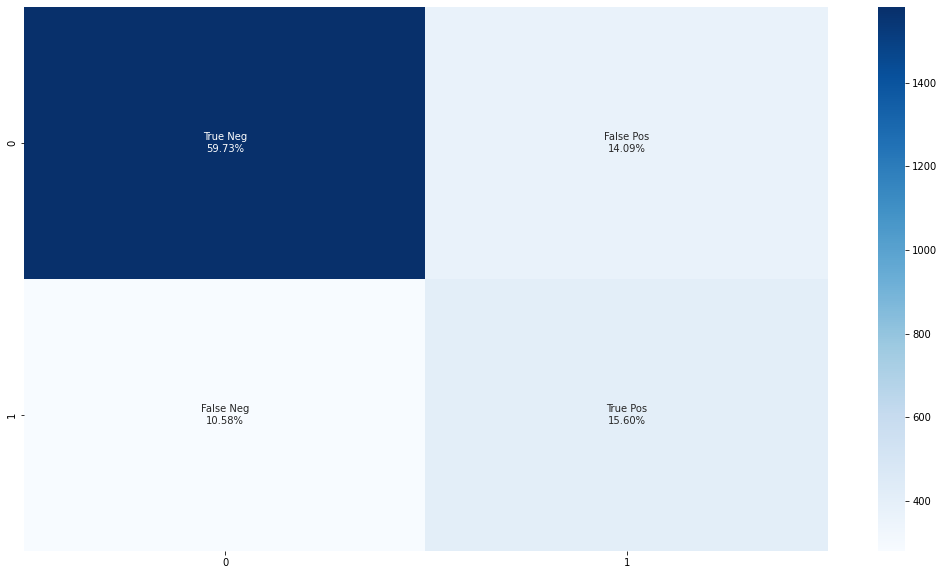

In [176]:
plot_confusion_matrix(y_true_test, y_pred)

#### Performance Commentary

**Initial Performance**  
At first, Neural Network I was very simple, starting with an embedding layer, only one convolutional layer, and then ending with a typical flatten/dense/dropout output setup. This preliminary model had terrible performance! Overfitting occured within 5 epochs, with a training accuracy of 99.91%. The model scored an accuracy 73.29% on the validation dataset, which seemed ok. Upon closer inspection, it was apparent that the model was simply guessing "negative" for every example and the validation dataset happened to be 73.29% negative labels!

**Post-Tuning Performance**  
To improve performance, we added a batch normalization layer followed by 2 more convolutional layers. Each convolutional layer was separated with a dropout layer and a max pooling layer. After the convolutional layers, a 250 node dense layer and another dropout layer was added. This improved the validation accuracy of Neural Network I to 79%. More importantly, we achieved better performance on the positive case, going from a 0% TP rate to a 13.45% TP rate. This is still not great, so we decided to run a more complex NN, with specific layers designed for text classification.

## Neural Network II

#### Initial Model Training

In [177]:
from tensorflow.keras import layers

# SRC: Keras Docs
class TransformerBlock(layers.Layer):
    def __init__(self, embed_dim, num_heads, ff_dim, rate=0.25):
        super(TransformerBlock, self).__init__()
        self.att = layers.MultiHeadAttention(num_heads=num_heads, key_dim=embed_dim)
        self.ffn = keras.Sequential(
            [layers.Dense(ff_dim, activation="relu"), layers.Dense(embed_dim),]
        )
        self.layernorm1 = layers.LayerNormalization(epsilon=1e-6)
        self.layernorm2 = layers.LayerNormalization(epsilon=1e-6)
        self.dropout1 = layers.Dropout(rate)
        self.dropout2 = layers.Dropout(rate)

    def call(self, inputs, training):
        attn_output = self.att(inputs, inputs)
        attn_output = self.dropout1(attn_output, training=training)
        out1 = self.layernorm1(inputs + attn_output)
        ffn_output = self.ffn(out1)
        ffn_output = self.dropout2(ffn_output, training=training)
        return self.layernorm2(out1 + ffn_output)

In [178]:
class TokenAndPositionEmbedding(layers.Layer):
    def __init__(self, maxlen, vocab_size, embed_dim):
        super(TokenAndPositionEmbedding, self).__init__()
        self.token_emb = layers.Embedding(input_dim=vocab_size, output_dim=embed_dim)
        self.pos_emb = layers.Embedding(input_dim=maxlen, output_dim=embed_dim)

    def call(self, x):
        maxlen = tf.shape(x)[-1]
        positions = tf.range(start=0, limit=maxlen, delta=1)
        positions = self.pos_emb(positions)
        x = self.token_emb(x)
        return x + positions

In [179]:
# Number of attention heads
NUM_HEADS = 2
# Embedding size for each token
EMBED_DIM = 32
# Hidden layer size in feed forward network inside transformer
FF_DIM = 32

In [180]:
inputs = layers.Input(shape=(MAX_LENGTH,))
embedding_layer = TokenAndPositionEmbedding(
    MAX_LENGTH, num_unique_words, EMBED_DIM
)
x = embedding_layer(inputs)

In [181]:
transformer_block = TransformerBlock(
    EMBED_DIM, NUM_HEADS, FF_DIM
)
x = transformer_block(x)
x = layers.GlobalAveragePooling1D()(x)
x = layers.Dropout(0.5)(x)
x = layers.Dense(40, activation="relu")(x)
x = layers.Dropout(0.5)(x)
outputs = layers.Dense(1, activation="sigmoid")(x)

In [182]:
model_2 = keras.Model(
    inputs=inputs, outputs=outputs
)

In [183]:
model_2.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 70)]              0         
                                                                 
 token_and_position_embeddin  (None, 70, 32)           512224    
 g (TokenAndPositionEmbeddin                                     
 g)                                                              
                                                                 
 transformer_block (Transfor  (None, 70, 32)           10656     
 merBlock)                                                       
                                                                 
 global_average_pooling1d (G  (None, 32)               0         
 lobalAveragePooling1D)                                          
                                                                 
 dropout_22 (Dropout)        (None, 32)                0     

In [184]:
# our model starts to overfit after only a few iterations so we have to stop the training early 
model_2.compile(
    loss='binary_crossentropy',
    optimizer='adam',
    metrics=['accuracy']
)
new_history = model_2.fit(
    train_padded,
    y_true_train,
    epochs=5,
    validation_data=(val_padded, y_true_val)
)

Epoch 1/5
99/99 [==============================] - 6s 43ms/step - loss: 0.6440 - accuracy: 0.6864 - val_loss: 0.5864 - val_accuracy: 0.7329
Epoch 2/5
99/99 [==============================] - 4s 41ms/step - loss: 0.5963 - accuracy: 0.7257 - val_loss: 0.6413 - val_accuracy: 0.7329
Epoch 3/5
99/99 [==============================] - 4s 40ms/step - loss: 0.5849 - accuracy: 0.7276 - val_loss: 0.5835 - val_accuracy: 0.7329
Epoch 4/5
99/99 [==============================] - 4s 40ms/step - loss: 0.4880 - accuracy: 0.7656 - val_loss: 0.4294 - val_accuracy: 0.8127
Epoch 5/5
99/99 [==============================] - 4s 40ms/step - loss: 0.2459 - accuracy: 0.9151 - val_loss: 0.5089 - val_accuracy: 0.8253


In [185]:
y_pred = model_2.predict(test_padded)

In [186]:
TRESHOLD = 0.5
y_pred = [
    1 if y_pred[i] >= TRESHOLD else 0
    for i in range(y_pred.shape[0])
]

In [187]:
print(classification_report(y_true_test, y_pred))

              precision    recall  f1-score   support

           0       0.83      0.94      0.88      1954
           1       0.74      0.47      0.58       693

    accuracy                           0.82      2647
   macro avg       0.79      0.71      0.73      2647
weighted avg       0.81      0.82      0.80      2647



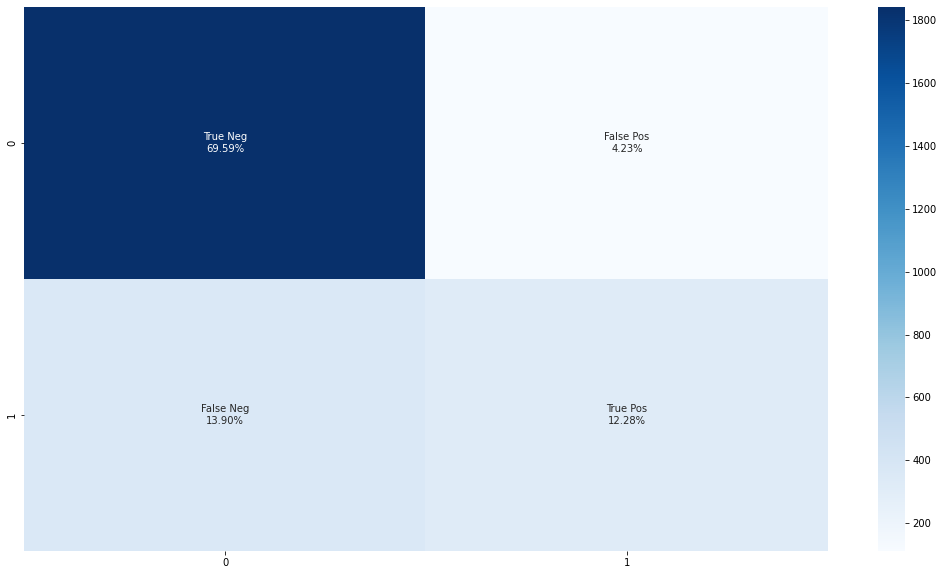

In [188]:
plot_confusion_matrix(y_true_test, y_pred)

#### Hyperparameter Tuning

In [189]:
!pip install -q -U keras-tuner

import keras_tuner as kt

###Hyperparameter Tuning NN1

In [190]:
# Used for hyperparameter tuning, taken from Keras Docs
def model1_builder(hp):
    """
    @param hp - hyperparameter values
    """
    model = tf.keras.Sequential()

    model.add(tf.keras.layers.Embedding(
        num_unique_words, EMBED_DIM, input_length=MAX_LENGTH
    ))

    # Tune the number of filters in the first Conv1D layer
    model.add(tf.keras.layers.Conv1D(
        filters=hp.Int('filters', min_value=32, max_value=128, step = 32),
        kernel_size=5,
        activation='relu',
        padding="same"))
    model.add(tf.keras.layers.BatchNormalization())
    model.add(tf.keras.layers.Dropout(.2))
    model.add(tf.keras.layers.MaxPool1D())

    model.add(tf.keras.layers.Conv1D(
        filters=hp.Int('filters', min_value=32, max_value=128, step = 32),
        kernel_size=3,
        activation='relu',
        padding="same"))
    model.add(tf.keras.layers.Dropout(.2))
    model.add(tf.keras.layers.MaxPool1D())

    model.add(tf.keras.layers.Conv1D(
        filters=hp.Int('filters', min_value=32, max_value=128, step = 32),
        kernel_size=3,
        activation='relu',
        padding="same"))
    model.add(tf.keras.layers.Dropout(.2))
    model.add(tf.keras.layers.MaxPool1D())
    model.add(tf.keras.layers.Flatten())

    # Tune the number of units in the first Dense layer
    # hp_units = hp.Int('units', min_value=32, max_value=512, step=32)
    model.add(tf.keras.layers.Dense(
        units=hp.Int('units', min_value=32, max_value=512, step=32), 
        activation='relu'))
    model.add(tf.keras.layers.Dropout(.5))

    model.add(tf.keras.layers.Dense(
        units=hp.Int('units', min_value=32, max_value=512, step=32), 
        activation='relu'))    
    model.add(tf.keras.layers.Dropout(.25))
    model.add(tf.keras.layers.Dense(1, activation='sigmoid'))

    # Tune the learning rate for the optimizer
    hp_learning_rate = hp.Choice('learning_rate', values=[1e-2, 1e-3, 1e-4])
    optimizer = tf.keras.optimizers.Nadam(hp_learning_rate)

    # Compile the model 
    model.compile(
    loss='binary_crossentropy',
    optimizer=optimizer,
    metrics=['accuracy',tf.keras.metrics.Precision(),tf.keras.metrics.Recall()]
    )

    return model

In [191]:
# We need to make our models hypermodels
# see https://www.tensorflow.org/tutorials/keras/keras_tuner
tuner_recall = kt.Hyperband(model1_builder,
                     objective=kt.Objective("recall", direction="max"),
                     max_epochs=5,
                     factor=3,
                     project_name='neural_net_hp_tuning_recall_obj',
                     )

tuner_acc = kt.Hyperband(model1_builder,
                     objective="val_accuracy",
                     max_epochs=5,
                     factor=3,
                     project_name='neural_net_hp_tuning_acc_obj',
                     )

INFO:tensorflow:Reloading Oracle from existing project ./neural_net_hp_tuning_acc_obj/oracle.json
INFO:tensorflow:Reloading Tuner from ./neural_net_hp_tuning_acc_obj/tuner0.json


In [192]:
stop_early = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=5)

In [193]:
tuner_acc.search(train_padded, y_true_train, epochs=10, validation_data=(val_padded, y_true_val), callbacks=[stop_early])

INFO:tensorflow:Oracle triggered exit


In [194]:
best_hps=tuner_acc.get_best_hyperparameters(num_trials=1)[0]

print(f"""
The optimal number of filters in the Convolution layers is {best_hps.get('filters')}.
The optimal number of units in the densely-connected layers is {best_hps.get('units')} 
The optimal learning rate for the optimizer is {best_hps.get('learning_rate')}.
""")


The optimal number of filters in the Convolution layers is 32.
The optimal number of units in the densely-connected layers is 160 
The optimal learning rate for the optimizer is 0.001.



In [195]:
model = tuner_acc.hypermodel.build(best_hps)
history = model.fit(train_padded, y_true_train, epochs=10, validation_data=(val_padded, y_true_val))

val_acc_per_epoch = history.history['val_accuracy']
best_epoch = val_acc_per_epoch.index(max(val_acc_per_epoch)) + 1
print('Best epoch: %d' % (best_epoch,))

Epoch 1/10
99/99 [==============================] - 5s 28ms/step - loss: 0.5966 - accuracy: 0.7273 - precision_6: 0.1034 - recall_6: 0.0036 - val_loss: 0.6583 - val_accuracy: 0.7329 - val_precision_6: 0.0000e+00 - val_recall_6: 0.0000e+00
Epoch 2/10
99/99 [==============================] - 2s 24ms/step - loss: 0.5501 - accuracy: 0.7349 - precision_6: 1.0000 - recall_6: 0.0012 - val_loss: 0.6908 - val_accuracy: 0.7329 - val_precision_6: 0.0000e+00 - val_recall_6: 0.0000e+00
Epoch 3/10
99/99 [==============================] - 2s 24ms/step - loss: 0.3811 - accuracy: 0.8204 - precision_6: 0.7571 - recall_6: 0.4761 - val_loss: 0.8487 - val_accuracy: 0.2709 - val_precision_6: 0.2681 - val_recall_6: 1.0000
Epoch 4/10
99/99 [==============================] - 2s 23ms/step - loss: 0.1716 - accuracy: 0.9344 - precision_6: 0.8647 - recall_6: 0.8926 - val_loss: 0.9269 - val_accuracy: 0.3177 - val_precision_6: 0.2790 - val_recall_6: 0.9810
Epoch 5/10
99/99 [==============================] - 2s 23ms/

In [196]:
tuner_recall.search(train_padded, y_true_train, epochs=10, validation_data=(val_padded, y_true_val), callbacks=[stop_early])

Trial 10 Complete [00h 00m 15s]
recall: 0.8389021754264832

Best recall So Far: 0.9701670408248901
Total elapsed time: 00h 02m 42s
INFO:tensorflow:Oracle triggered exit


In [197]:
best_hps_recall=tuner_recall.get_best_hyperparameters(num_trials=1)[0]

print(f"""
The optimal number of filters in the Convolution layers is {best_hps_recall.get('filters')}.
The optimal number of units in the densely-connected layers is {best_hps_recall.get('units')} 
The optimal learning rate for the optimizer is {best_hps_recall.get('learning_rate')}.
""")


The optimal number of filters in the Convolution layers is 96.
The optimal number of units in the densely-connected layers is 32 
The optimal learning rate for the optimizer is 0.001.



In [198]:
recall_model = tuner_recall.hypermodel.build(best_hps_recall)
recall_history = recall_model.fit(train_padded, y_true_train, epochs=10, validation_data=(val_padded, y_true_val))

val_acc_per_epoch = recall_history.history['val_accuracy']
best_epoch = val_acc_per_epoch.index(max(val_acc_per_epoch)) + 1
print('Best epoch: %d' % (best_epoch,))

Epoch 1/10
99/99 [==============================] - 7s 44ms/step - loss: 0.6019 - accuracy: 0.7257 - precision_1: 0.2812 - recall_1: 0.0215 - val_loss: 0.6551 - val_accuracy: 0.7329 - val_precision_1: 0.0000e+00 - val_recall_1: 0.0000e+00
Epoch 2/10
99/99 [==============================] - 4s 39ms/step - loss: 0.5558 - accuracy: 0.7349 - precision_1: 0.6000 - recall_1: 0.0036 - val_loss: 0.6571 - val_accuracy: 0.7329 - val_precision_1: 0.0000e+00 - val_recall_1: 0.0000e+00
Epoch 3/10
99/99 [==============================] - 4s 39ms/step - loss: 0.3627 - accuracy: 0.8347 - precision_1: 0.7724 - recall_1: 0.5346 - val_loss: 0.6398 - val_accuracy: 0.6633 - val_precision_1: 0.4278 - val_recall_1: 0.7725
Epoch 4/10
99/99 [==============================] - 4s 38ms/step - loss: 0.1451 - accuracy: 0.9515 - precision_1: 0.9122 - recall_1: 0.9045 - val_loss: 0.5466 - val_accuracy: 0.7532 - val_precision_1: 0.5303 - val_recall_1: 0.6635
Epoch 5/10
99/99 [==============================] - 4s 39ms/

###Hyperparameter Tuning NN2

In [199]:
def model2_builder(hp):
    """
    @param hp - hyperparameter values
    """
    inputs = layers.Input(shape=(MAX_LENGTH,))
    embedding_layer = TokenAndPositionEmbedding(
      MAX_LENGTH, num_unique_words, EMBED_DIM
    )
    x = embedding_layer(inputs)
    transformer_block = TransformerBlock(
    EMBED_DIM, NUM_HEADS, FF_DIM
    )
    x = transformer_block(x)
    x = layers.GlobalAveragePooling1D()(x)
    x = layers.Dropout(0.5)(x)
    hp_units=hp.Int('units', min_value=32, max_value=512, step=32)
    x = layers.Dense(units=hp_units, activation="relu")(x)
    x = layers.Dropout(0.5)(x)
    outputs = layers.Dense(1, activation="sigmoid")(x)

    # Tune the learning rate for the optimizer
    hp_learning_rate = hp.Choice('learning_rate', values=[1e-2, 1e-3, 1e-4])
    optimizer = tf.keras.optimizers.Nadam(hp_learning_rate)

    model = keras.Model(inputs=inputs, outputs=outputs)

    # Compile the model 
    model.compile(
    loss='binary_crossentropy',
    optimizer=optimizer,
    metrics=['accuracy',tf.keras.metrics.Precision(),tf.keras.metrics.Recall()]
    )

    return model

In [200]:
tuner2_acc = kt.Hyperband(model2_builder,
                     objective="val_accuracy",
                     max_epochs=5,
                     factor=3,
                     project_name='neural_net_2_hp_tuning_acc_obj',
                     )

In [201]:
tuner2_acc.search(train_padded, y_true_train, epochs=10, validation_data=(val_padded, y_true_val), callbacks=[stop_early])

Trial 10 Complete [00h 00m 25s]
val_accuracy: 0.7329114079475403

Best val_accuracy So Far: 0.7898734211921692
Total elapsed time: 00h 03m 27s
INFO:tensorflow:Oracle triggered exit


In [202]:
best_hps_model2=tuner2_acc.get_best_hyperparameters(num_trials=1)[0]

print(f"""
The optimal number of units in the densely-connected layers is {best_hps_model2.get('units')} 
The optimal learning rate for the optimizer is {best_hps_model2.get('learning_rate')}.
""")


The optimal number of units in the densely-connected layers is 320 
The optimal learning rate for the optimizer is 0.01.



In [203]:
model2 = tuner_acc.hypermodel.build(best_hps_recall)
model2_history = model2.fit(train_padded, y_true_train, epochs=10, validation_data=(val_padded, y_true_val))

val_acc_per_epoch = model2_history.history['val_accuracy']
best_epoch = val_acc_per_epoch.index(max(val_acc_per_epoch)) + 1
print('Best epoch: %d' % (best_epoch,))

Epoch 1/10
99/99 [==============================] - 7s 43ms/step - loss: 0.5984 - accuracy: 0.7339 - precision_1: 0.4000 - recall_1: 0.0048 - val_loss: 0.6577 - val_accuracy: 0.7329 - val_precision_1: 0.0000e+00 - val_recall_1: 0.0000e+00
Epoch 2/10
99/99 [==============================] - 4s 38ms/step - loss: 0.5451 - accuracy: 0.7346 - precision_1: 0.0000e+00 - recall_1: 0.0000e+00 - val_loss: 0.6626 - val_accuracy: 0.7329 - val_precision_1: 0.0000e+00 - val_recall_1: 0.0000e+00
Epoch 3/10
99/99 [==============================] - 4s 38ms/step - loss: 0.3611 - accuracy: 0.7947 - precision_1: 0.8442 - recall_1: 0.2780 - val_loss: 0.6640 - val_accuracy: 0.5810 - val_precision_1: 0.3790 - val_recall_1: 0.8910
Epoch 4/10
99/99 [==============================] - 4s 39ms/step - loss: 0.2306 - accuracy: 0.9427 - precision_1: 0.8944 - recall_1: 0.8890 - val_loss: 0.5477 - val_accuracy: 0.6911 - val_precision_1: 0.4516 - val_recall_1: 0.7299
Epoch 5/10
99/99 [==============================] - 

#### Performance Commentary

Neural Network II (NNII) had slightly better performance than Neural Network I (NNI); 82% accuracy compared to 79%. The main improvement was that NNII was able to recognize the positive class a lot better than NNI. True positives and false negatives had slightly better performance. The false positives category improved the most, decreasing by more than 2%, from 7.9% to 5.7%. This improved performance comes from the usage of layers specialized for text classification, the TransformerBlock and the TokenAndPosition embedding.


# 7) Conclusions

While we made significant improvements in performance with the neural networks, the best performance still came from the SVM model. NNII had 82% accuracy, the second highest of any model. SVM had 83% accuracy and the best recognition of the positive case. 